# Question 1

Based on the given dataset, some possible use cases are as follows:

 - Understanding how products are sold together - via basket analysis for example - which in turn can be used to build a optimal store (website) layout.
 - Forecasting the mean sales values, in order to think about the direction of the business in the short and medium term.
 - Forecasting items sales, to have a better stock control.
 - Making a model to understand and predict which clients will abandon the company, and then think in a proper way to retain the profitable ones. 
 - There is already a group_code but a more efficiently method can be used to cluster clients and determine better profiles.
 - Understand sales operation as a whole by making a good descriptive analysis, like the top sold items or top profitables clients, top employees, check employees performance overtime, verify problems with employees and channel by checking churn and so on.

# Question 2

Churn models were created based on a real business need of the telecommunication sector. Companies needed to understand which of there clients had high risk of cancelling their contracts and move to the competitor. This type of situation its still a problem today, worse even so, since companies grow in number and the competition is much more intense with clients ever so eager to a better product, or service or attendance.

With this situation in mind, developing a model that can predict which of ones clients have a greater risk to leave his company has a huge impact because can aid the company to retain the profitables clients by making a target campaign and speak directly to those who matter in the best and most efficiently way possible, reducing their company's risk, helping than to save money with inefficiently marketing and helping create a better image in the eyes of the clients.


# Questions 3 and 4

The code was written using pure R language with the following configuration:

platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          4.3                         
year           2017                        
month          11                          
day            30                          
svn rev        73796                       
language       R                           
version.string R version 3.4.3 (2017-11-30)
nickname       Kite-Eating Tree  

Packages Version:
 - jsonlite: 1.5
 - data.table: 1.10.4.3
 - stringi: 1.1.7
 - lubridate: 1.7.2
 - caret: 6.0.78
 - pROC: 1.10.0
 - PRROC: 1.3


## ETL procedures

In [1]:
# Importing libraries

#manage json files
library(jsonlite)
#efficienty dataframe-like structure
library(data.table)
#string operations
library(stringi)
#date operations
library(lubridate)
#statistical and ml library
library(caret)
#performance functions
#Area Under Roc Curve
library(pROC)
#Area Under Precision x Recall Curve
library(PRROC)


Attaching package: ‘lubridate’

The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from ‘package:base’:

    date

Loading required package: lattice
Loading required package: ggplot2
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



Reads the json file located in the same folder and converts to a datatable structure, which is faster and more memory efficient than the default R dataframe format.

In [2]:
data = as.data.table(read_json("./challenge.json",simplifyVector = T))

# check columns type
str(data)

Classes ‘data.table’ and 'data.frame':	204428 obs. of  14 variables:
 $ customer_code   : int  143 433 486 107 768 740 58 408 25 58 ...
 $ branch_id       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sales_channel   : int  0 1 0 1 1 8 0 1 0 1 ...
 $ seller_code     : int  190 153 166 156 218 213 179 199 94 179 ...
 $ register_date   : chr  "2017-11-10T00:00:00Z" "2011-05-16T00:00:00Z" "2018-01-24T00:00:00Z" "2010-07-28T00:00:00Z" ...
 $ total_price     : num  1614 11164 6432 832 1736 ...
 $ order_id        : int  21804 5486 22662 3956 4730 1835 11450 2504 21773 843 ...
 $ quantity        : int  10 20 12 18 5 10 6 6 10 2 ...
 $ item_code       : int  854 246 1420 1963 1786 2854 246 1842 1767 410 ...
 $ item_total_price: num  292.9 287.2 184.8 189.2 66.9 ...
 $ unit_price      : num  25 12.3 12.8 10.5 11.8 ...
 $ group_code      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ segment_code    : int  0 5 0 0 0 0 0 0 0 0 ...
 $ is_churn        : chr  "0" "0" "0" "0" ...
 - attr(*, ".internal.selfref")=<externalptr>

I removed the time part of the string since there is no relevant information about it (it is the same for all values) and so I keep just the date part, convert to a proper date class to speedy up the processing time using optimized date functions and filters.

In [3]:
data[, register_date := as.Date(substr(register_date,1,10), format = "%Y-%m-%d")]

#Set row order to easy visualization
setorder(data,customer_code, register_date)

It is always a good idea to summarize the data in order to understand some overall aspects of it, for example: Above we can see that the field branch_id has only one value (because the minimum is equal to the maximum), and also there are probably some outliers within the data since there is a huge value of items sold (quantity) and total_price, away far off the 3rd quantile.

In [4]:
summary(data)

# drop branch_id once it is irrelevant to the studied
data[, branch_id := NULL]

 customer_code     branch_id sales_channel      seller_code   
 Min.   :  0.0   Min.   :0   Min.   :  0.000   Min.   :  0.0  
 1st Qu.:221.0   1st Qu.:0   1st Qu.:  0.000   1st Qu.: 83.0  
 Median :486.0   Median :0   Median :  0.000   Median :156.0  
 Mean   :447.5   Mean   :0   Mean   :  1.761   Mean   :145.5  
 3rd Qu.:651.0   3rd Qu.:0   3rd Qu.:  2.000   3rd Qu.:195.0  
 Max.   :837.0   Max.   :0   Max.   :105.000   Max.   :289.0  
 register_date         total_price        order_id        quantity      
 Min.   :2008-01-04   Min.   :     0   Min.   :    0   Min.   :   1.00  
 1st Qu.:2011-10-28   1st Qu.:  1180   1st Qu.: 6498   1st Qu.:   3.00  
 Median :2014-07-22   Median :  2036   Median :12698   Median :   6.00  
 Mean   :2014-03-15   Mean   :  5337   Mean   :12434   Mean   :  12.33  
 3rd Qu.:2016-11-21   3rd Qu.:  3611   3rd Qu.:18280   3rd Qu.:  12.00  
 Max.   :2018-07-08   Max.   :428976   Max.   :24617   Max.   :7000.00  
   item_code    item_total_price     unit_price 

Given a quick look over the data it is possible to see that some values are incorrect, such as the item_total_price, that should be $quantity \times unit\_price$ but $12 \times 9.06$ (taking the first row) should be $108.72$ instead of the current value of $135.35$

In [5]:
data[customer_code == '0' & register_date == '2008-09-23'][order(item_code)]

customer_code,sales_channel,seller_code,register_date,total_price,order_id,quantity,item_code,item_total_price,unit_price,group_code,segment_code,is_churn
0,8,153,2008-09-23,4721.62,967,12,356,135.35,9.06,0,0,0
0,8,153,2008-09-23,4721.62,967,24,357,389.01,13.02,0,0,0
0,8,153,2008-09-23,4721.62,967,12,719,291.91,19.54,0,0,0
0,8,153,2008-09-23,4721.62,967,12,721,627.15,41.98,0,0,0
0,8,153,2008-09-23,4721.62,967,12,722,1063.67,71.20,0,0,0
0,8,153,2008-09-23,4721.62,967,12,1956,187.19,12.53,0,0,0
0,8,153,2008-09-23,4721.62,967,12,1957,195.85,13.11,0,0,0
0,8,153,2008-09-23,4721.62,967,6,1958,144.91,19.40,0,0,0
0,8,153,2008-09-23,4721.62,967,6,1960,234.25,31.36,0,0,0
0,8,153,2008-09-23,4721.62,967,6,1961,360.85,48.31,0,0,0


Another problem with this dataset is that some items, such as $934$ below, were not aggregated and so there is unnecessary rows repetition, in order $15469$ for instance.

In [6]:
data[customer_code == '158' & register_date == '2015-10-04'][order(item_code)]

customer_code,sales_channel,seller_code,register_date,total_price,order_id,quantity,item_code,item_total_price,unit_price,group_code,segment_code,is_churn
158,0,50,2015-10-04,47.14,15469,6,465,1.73,0.25,0,0,0
158,0,50,2015-10-04,47.14,15469,1,934,1.14,0.99,0,0,0
158,0,50,2015-10-04,47.14,15469,1,934,1.14,0.99,0,0,0
158,0,50,2015-10-04,47.14,15469,1,934,1.14,0.99,0,0,0
158,0,50,2015-10-04,47.14,15469,1,934,1.14,0.99,0,0,0
158,0,50,2015-10-04,47.14,15469,1,934,1.14,0.99,0,0,0
158,0,50,2015-10-04,47.14,15469,4,1864,0.83,0.18,0,0,0
158,0,50,2015-10-04,47.14,15469,2,1866,2.81,1.22,0,0,0
158,0,50,2015-10-04,47.14,15469,1,1866,1.40,1.22,0,0,0
158,0,50,2015-10-04,47.14,15469,1,1866,1.40,1.22,0,0,0


The problems described above were fixed in the next chunk of code. For this I assumed that the quantity and unit_price information were inputed correctly and so I used then and aggregated the values considering customer_code, register_date and order_id (the other column were used just so I wouldn't drop then). Once the values were correctly aggregated, therefor removing rows repetition, I calculated the correct item_total_price and total_price.

In [8]:
#define categorical variables to help automate functions, improve performance and a better cleaner code
factor_cols = c(
  "customer_code",
  "sales_channel",
  "seller_code",
  "order_id",
  "item_code",
  "group_code",
  "segment_code",
  "is_churn"
)

#hard copy of the data to a new variable
fixed_data = copy(data)

#Agregates quantity and unit_price. 
#Since unit_price is the same for all observations I can take the mean without any problem 
fixed_data = fixed_data[, .(quantity = sum(quantity),
                            unit_price = mean(unit_price)), by = c(factor_cols, 'register_date')]

#Calculate additional variables
fixed_data[, item_total_price := quantity * unit_price]
fixed_data[, total_price := sum(item_total_price), by = .(customer_code, register_date, order_id)]

#Creates an auxiliary column setting a date by month
fixed_data[, monthly_date := as.Date(paste0(
  lubridate::year(register_date),
  '-',
  lubridate::month(register_date),
  '-01'
),
format = "%Y-%m-%d")]

We can see that now the same situations have no problems

In [9]:
fixed_data[customer_code == '0' & register_date == '2008-09-23'][order(item_code)]

customer_code,sales_channel,seller_code,order_id,item_code,group_code,segment_code,is_churn,register_date,quantity,unit_price,item_total_price,total_price,monthly_date
0,8,153,967,356,0,0,0,2008-09-23,12,9.06,108.72,4721.62,2008-09-01
0,8,153,967,357,0,0,0,2008-09-23,24,13.02,312.48,4721.62,2008-09-01
0,8,153,967,719,0,0,0,2008-09-23,12,19.54,234.48,4721.62,2008-09-01
0,8,153,967,721,0,0,0,2008-09-23,12,41.98,503.76,4721.62,2008-09-01
0,8,153,967,722,0,0,0,2008-09-23,12,71.20,854.40,4721.62,2008-09-01
0,8,153,967,1956,0,0,0,2008-09-23,12,12.53,150.36,4721.62,2008-09-01
0,8,153,967,1957,0,0,0,2008-09-23,12,13.11,157.32,4721.62,2008-09-01
0,8,153,967,1958,0,0,0,2008-09-23,6,19.40,116.40,4721.62,2008-09-01
0,8,153,967,1960,0,0,0,2008-09-23,6,31.36,188.16,4721.62,2008-09-01
0,8,153,967,1961,0,0,0,2008-09-23,6,48.31,289.86,4721.62,2008-09-01


In [10]:
fixed_data[customer_code == '158' & register_date == '2015-10-04'][order(item_code)]

customer_code,sales_channel,seller_code,order_id,item_code,group_code,segment_code,is_churn,register_date,quantity,unit_price,item_total_price,total_price,monthly_date
158,0,50,15469,465,0,0,0,2015-10-04,6,0.25,1.50,47.14,2015-10-01
158,0,50,15469,934,0,0,0,2015-10-04,5,0.99,4.95,47.14,2015-10-01
158,0,50,15469,1864,0,0,0,2015-10-04,4,0.18,0.72,47.14,2015-10-01
158,0,50,15469,1866,0,0,0,2015-10-04,5,1.22,6.10,47.14,2015-10-01
158,0,50,15469,1871,0,0,0,2015-10-04,1,1.02,1.02,47.14,2015-10-01
158,0,50,15469,1948,0,0,0,2015-10-04,7,0.39,2.73,47.14,2015-10-01
158,0,50,15469,1971,0,0,0,2015-10-04,1,1.89,1.89,47.14,2015-10-01
158,0,50,15469,2076,0,0,0,2015-10-04,3,0.11,0.33,47.14,2015-10-01
158,0,50,15469,2263,0,0,0,2015-10-04,2,1.58,3.16,47.14,2015-10-01
158,0,50,15469,2264,0,0,0,2015-10-04,1,0.23,0.23,47.14,2015-10-01


Another indispensable step in data science, and modeling specially, is feature engineering, which consists in the creation of features based on the existent content of each dataset. So, in order to make a churn model some transformation in the dataset is needed. I aggregated the variables by month and year, using the auxiliary variable __monthly_date__, because I will create some features that requires the data to be in a monthly frequency.

In the next step I count, by month, the total distinct values of sales channel, sellers, orders, items, and also the total amount of items sold and the value of the sales and I also keep the information of group, segment and churn of each customer.

In [11]:
#changes the type of string to integer to facilitate notation and reduce memory consumption
fixed_data[, is_churn := as.integer(is_churn)]

agg_data = fixed_data[, .(
  n_channel = uniqueN(sales_channel),
  n_seller = uniqueN(seller_code),
  n_order = uniqueN(order_id),
  n_item = uniqueN(item_code),
  group_code = mean(group_code),
  segment_code = mean(segment_code),
  is_churn = max(as.integer(is_churn)),
  total_item = sum(quantity),
  total_value = sum(total_price)
), by = .(customer_code, monthly_date)]

Just knowing which client had churn by flagging every observation of it isn't enough, because more importantly than knowing the client is to know his behavior previously of exiting. This can be achieved be flagging just his last observation (based on the max date) and calculating several measures along the time he was a costumer.

In [12]:
#copy churn flag
agg_data[, will_abandon := is_churn]
#creates an additional column with the last date of each customer
agg_data[, max_date := max(monthly_date), by = customer_code]
#For those clients that churn, keeps the flag only in the last observation and changes the rest to 0
agg_data[will_abandon == 1 &
           monthly_date != max_date, will_abandon := 0]

#Changes categorical variables to a proper type, needed to fit and apply models
agg_data[, c(factor_cols[factor_cols %in% names(agg_data)], 'will_abandon') := 
         lapply(.SD, as.factor),
         .SDcols = c(factor_cols[factor_cols %in%names(agg_data)], 'will_abandon')]

One type of feature that I thought about was to calculate the rate by the total number of orders in each month for each variable, so I would have the rate of items sold by the number of order; the rate of channels used by the number of order, so on so forth. This can be helpful to the model so it can differentiate sales that were big, from sales that seems big but actually represents a bunch of small sales that together has greater volume.

In [13]:
#define variables to help automate functions, improve performance and a better cleaner code
tx_variables = c("n_channel", "n_seller", "n_item", "total_item", "total_value")
#set the output name of columns that will be generated in the transformation by concatenating the variables
#with prefixes and suffixes
by_order = paste0("tx_", tx_variables, "_by_order")

#hard copy of the data to a new variable
churn_data = copy(agg_data)

#create new variables
churn_data[, c(by_order) := lapply(.SD, function(col) col/n_order),
                                   .SDcols = c(tx_variables)]

Another feature that I created was the first derivative of the observations. If we record our calculus class we know that the first derivative represents the growth ratio of a curve, which can be used to determine if a function is increasing or decreasing in a specific point and how fast. The same concept can be used here, we can compute this value to help the model understand if the client's consumption behavior is increasing or decreasing over time and how fast is this happening.

In order to calculate this I first needed to calculate the time between two sales for each customer and than used a discrete approximation of the first derivative by using the secant method $\frac{\Delta X}{\Delta time}$

I also calculate the difference between two consecutive sales to have a brute and raw value of comparison, kind of analogous to the first derivative but in case the observations were consecutives, i.e., differ by one day and so $\Delta time = 1$.

In [14]:
#Calculates time diff between two sales of each customer
churn_data[, time_between_shopping := as.numeric(difftime(monthly_date,
                                                          shift(monthly_date, 1),
                                                          units = 'days')),
           by = customer_code]

#define variables to help automate functions, improve performance and a better cleaner code
first_derivative_variables = c(tx_variables, by_order)
#set the output name of columns that will be generated in the transformation by concatenating the variables with
#prefixes
first_derivative_names = paste0("dr1_", first_derivative_variables)

#Calculates first derivative
churn_data[, c(first_derivative_names) := lapply(.SD, function(col)
  (col - shift(col, 1)) / time_between_shopping), by = customer_code, .SDcols = c(first_derivative_variables)]
                                                 
diff_names = paste0("diff_", first_derivative_variables)

churn_data[, c(diff_names) := lapply(.SD, function(col)
  col - shift(col, 1)), by = customer_code, .SDcols = c(first_derivative_variables)]

The last feature I created was the ration between last two trimesters. It's a well know feature in economy and in business in general, but usually used by quarters, since companies usually close their balances in this period. It's idea is analogous to the others ratios and the first derivative: it gives a sense of growth speed.

In [15]:
#define variables to help automate functions, improve performance and a better cleaner code 

#set the output name of columns that will be generated in the transformation by concatenating the variables with
#prefixes

last_observations_tx = paste0('last_obs_tx_', tx_variables)

#invert date order so that the most recently values comes first
setorder(churn_data, customer_code, -monthly_date)

#since it's ratio it can occur division by zero, when this happens the values is set to 0
last_observations_tx_data = churn_data[, lapply(.SD, function(col)
  ifelse(
    sum(col[1:3], na.rm = T) / sum(col[4:6], na.rm = T) == Inf,
    0,
    sum(col[1:3], na.rm = T) / sum(col[4:6], na.rm = T)
  )), by = customer_code, .SDcols = c(tx_variables)]

#change column names to doesn't mess up with join                                                
names(last_observations_tx_data) = c('customer_code', last_observations_tx)
                                                
#left join to put all variables together
churn_data = merge(churn_data,
                   last_observations_tx_data,
                   all.x = T,
                   by = 'customer_code')

Once all variables were created the information is then filtered in order to stay just with the last sale record of each customer, before he churns (or not), to build and apply a model just in the record that matters, since it's the only one that can really determine the behavior before exiting or not.

During the entire process I choose not to fill the blank spaces between sales with zeros to calculate all values and variables cause otherwise the matrix would be very sparse and the number of observation representing churn clients would be very small, implicating a rare event.

In [16]:
#Filter last observation and also the rows without is_churn values, 
#since this variable is the classification label, it can't have any abnormal value 
filtered_data = churn_data[monthly_date == max_date][!is.na(is_churn)]

#check for NAs in other variables
filtered_data[, lapply(.SD, function(x) sum(is.na(x)))]

#Replace NAs with 0                       
filtered_data[is.na(filtered_data)] = 0

#drop auxiliary, unneeded columns
filtered_data[, `:=` (
  is_churn = NULL,
  max_date = NULL,
  monthly_date = NULL,
  customer_code = NULL
)]

customer_code,monthly_date,n_channel,n_seller,n_order,n_item,group_code,segment_code,is_churn,total_item,⋯,diff_tx_n_channel_by_order,diff_tx_n_seller_by_order,diff_tx_n_item_by_order,diff_tx_total_item_by_order,diff_tx_total_value_by_order,last_obs_tx_n_channel,last_obs_tx_n_seller,last_obs_tx_n_item,last_obs_tx_total_item,last_obs_tx_total_value
0,0,0,0,0,0,0,0,0,0,⋯,1,1,1,1,1,0,0,0,0,0


## Modeling
### Preprocess procesures
## Modeling
### Preprocessing procedures
At this point we have a dataset with a just a few observations (818) and a lot of variables (40). To boost the model performance, both in processing time and accuracy, I decided to use a Principal Component Analysis to change my variables space, and then filter the significant components using the cumulative variance proportion criteria setting a level of 95% of captured variance, which resulted in just 13 principal components plus the clustering information about group and segment. In order to not input bias on the PCA, first I standardize the data using Z-Score normalization, i.e. $Z = \frac{X-\mu}{\sigma}$, this way the PCA is not biased by scale measure.

In [17]:
#define variables to help automate functions, improve performance and a better cleaner code
numerical_cols = c(
  tx_variables,
  'n_order',
  by_order,
  diff_names,
  'time_between_shopping',
  first_derivative_names,
  last_observations_tx
)

#standardize and fit PCA
preprocess_params = caret::preProcess(filtered_data[, .SD, .SDcols = numerical_cols],
                                      method = c("center", "scale", "pca"),
                                      thresh = 0.95)
#summary information of this preprocess procedure
preprocess_params

#apply preprocessing to data
transformed = predict(preprocess_params, filtered_data)

Created from 818 samples and 37 variables

Pre-processing:
  - centered (37)
  - ignored (0)
  - principal component signal extraction (37)
  - scaled (37)

PCA needed 13 components to capture 95 percent of the variance

### Building a model
To reduce over fitting I used a cross validation technique using 10 folds and 3 repetitions and to improve performance, measured by Accuracy information, I did a grid search to optimize the value of the mtry hyper parameter and kept the standard 500 ntrees. The grid searches all extent, start from the minimum 1 and goes as high as the total number of variables.

In [18]:
#choosing a seed value to random generation
seed = 112358
#set accuracy as a metric of performance to be improved
metric = "Accuracy"

#K-Fold cross validation with 10 folds and 3 repetitions
control = trainControl(
  method = "repeatedcv",
  number = 10,
  repeats = 3,
  search = "grid"
)
#Define grid search
tunegrid = expand.grid(.mtry = c(1:ncol(transformed)))

#Splits data into training and test set
idx = createDataPartition(transformed$will_abandon, p = 0.8, list = FALSE)
training = transformed[idx, ]
test = transformed[-idx, ]

I choose the Random Forest model because it is a well-known technique acknowledge by its robust result in most applications regardless of how one sets the hyper parameter, it is easy to understand, ergo interpretable at some extent. And specially because its separability surface in classification problems is very adaptable.

In [19]:
#Set random seed
set.seed(seed)

#Fit model
rf_gridsearch = train(
  will_abandon ~ .,
  data = training,
  method = "rf",
  metric = metric,
  tuneGrid = tunegrid,
  trControl = control
)

The plot shows how the mtry hyper parameter influences the model mean results and based on the table I can choose the specified mtry

Random Forest 

655 samples
 15 predictors
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 589, 589, 589, 589, 589, 590, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa      
   1    0.9013209  0.007652399
   2    0.9297591  0.464430627
   3    0.9343201  0.513130463
   4    0.9373893  0.554207991
   5    0.9399223  0.573067058
   6    0.9404351  0.581093648
   7    0.9399145  0.582612757
   8    0.9409479  0.593423458
   9    0.9383838  0.573382162
  10    0.9388967  0.578564425
  11    0.9378788  0.565342688
  12    0.9389044  0.577266021
  13    0.9368531  0.561557677
  14    0.9373582  0.566077479
  15    0.9368531  0.558778034
  16    0.9368531  0.570283662

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 8.


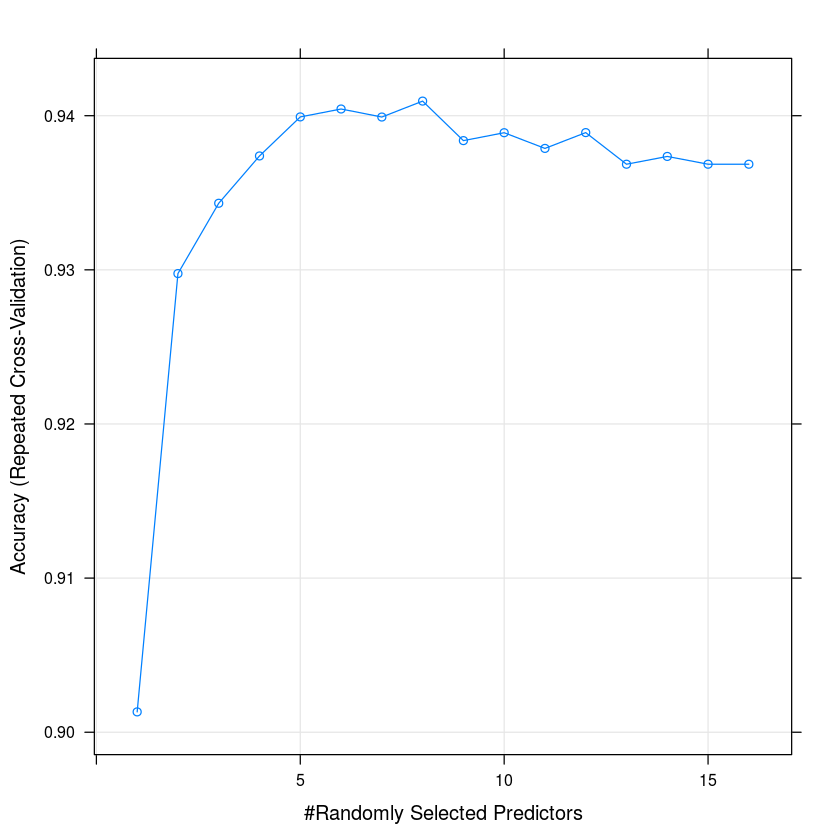

In [20]:
plot(rf_gridsearch)

print(rf_gridsearch)

### Model Evaluation
Using the model described above we can applied to both training set and test set and see how it behaves

In [21]:
#hard copy of the data to a new variable
output_training = copy(training)
#hard copy of the data to a new variable
output_test = copy(test)

#Gets each label class probability to test set
test_prediction_probability = predict(rf_gridsearch, test, type = "prob")

#Gets predicted class label of training set by the model 
output_training[, predicted := predict(rf_gridsearch, training)]

#Gets predicted class label of training set by the model 
output_test[, predicted := predict(rf_gridsearch, test)]

#Creates a column with the right probability measure
output_test[, prob := pmax(test_prediction_probability$`0`,
                           test_prediction_probability$`1`)]

As we can see, and imaging, the accuracy is outstanding when computed over the trainig set, providing 100% of accuracy and a narrow confidence interval 

In [22]:
#creates confusion matrix for training set
cm_training = confusionMatrix(output_training$predicted, output_training$will_abandon)
cm_training

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 590   0
         1   0  65
                                     
               Accuracy : 1          
                 95% CI : (0.9944, 1)
    No Information Rate : 0.9008     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.9008     
         Detection Rate : 0.9008     
   Detection Prevalence : 0.9008     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

Now, when we look to the test set, the results hold, which means that this model probably isn't over fitting and so it is generic enough to be applied in others subsets like those tested here

In [23]:
#creates confusion matrix for test set
cm_test = confusionMatrix(output_test$predicted, output_test$will_abandon)
cm_test

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 146  11
         1   1   5
                                          
               Accuracy : 0.9264          
                 95% CI : (0.8749, 0.9614)
    No Information Rate : 0.9018          
    P-Value [Acc > NIR] : 0.179540        
                                          
                  Kappa : 0.4237          
 Mcnemar's Test P-Value : 0.009375        
                                          
            Sensitivity : 0.9932          
            Specificity : 0.3125          
         Pos Pred Value : 0.9299          
         Neg Pred Value : 0.8333          
             Prevalence : 0.9018          
         Detection Rate : 0.8957          
   Detection Prevalence : 0.9632          
      Balanced Accuracy : 0.6528          
                                          
       'Positive' Class : 0               
                                          

However the accuracy isn't the best performance measure there is, since its raw count of hits and misses. A more sophisticated and robust measure is the area under the roc curve that is computed and plotted bellow. It show a measure greater than the default 70% threshold, corroborating previous results


Call:
roc.default(response = will_abandon, predictor = prob)

Data: prob in 147 controls (will_abandon 0) > 16 cases (will_abandon 1).
Area under the curve: 0.7972

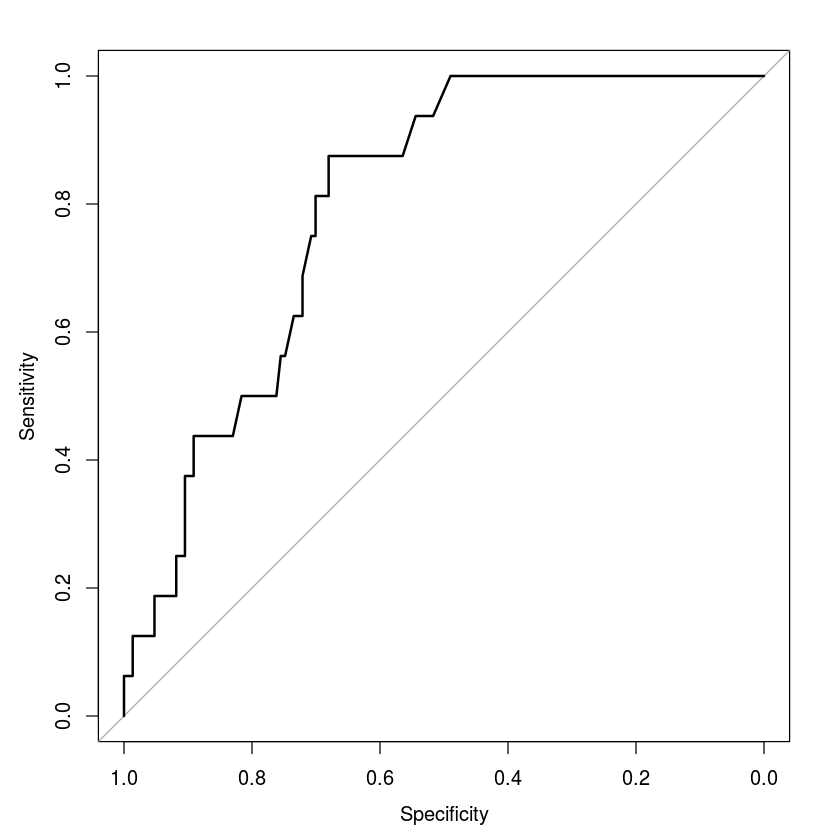

In [24]:
#calculates ROC AUC
roc = with(output_test, roc(will_abandon, prob))
roc
plot(roc)

As we are dealing with an unbalanced classification problem, one can also disregard the roc curve since it is often used to balanced problems. So, for last I propose the Area Under Precision x Recall Curve, that can handle unbalanced data better than ROC

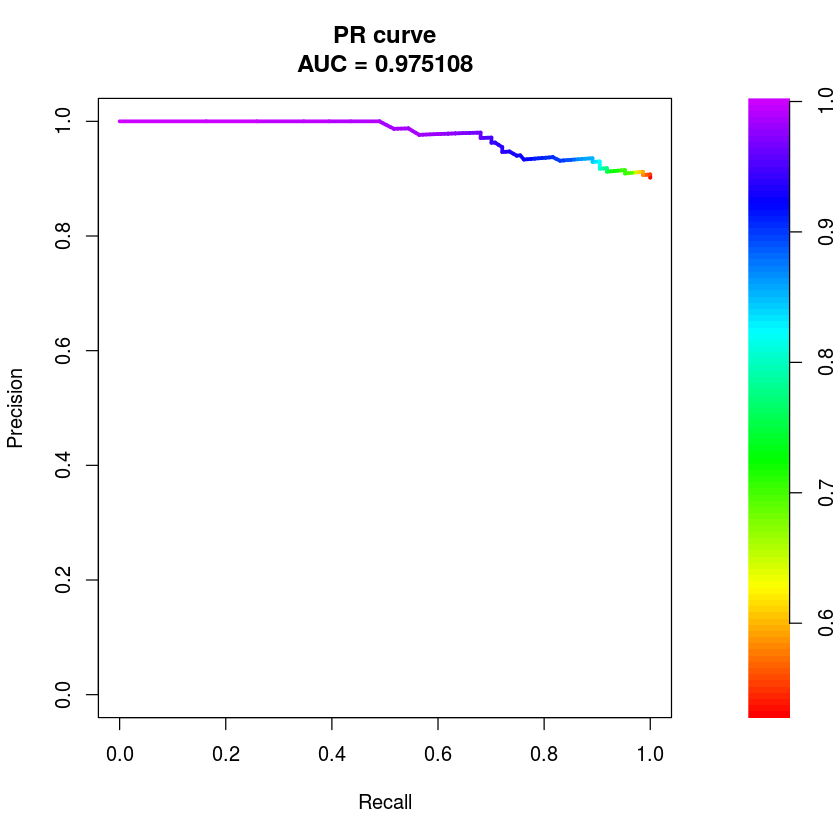

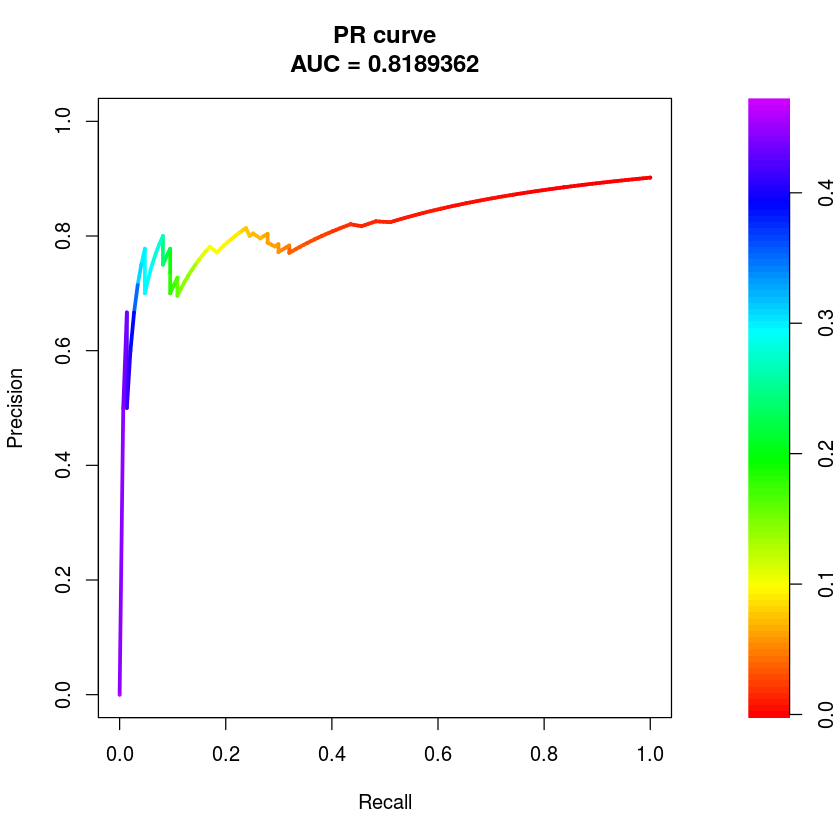

In [25]:
#calculates PR AUC for positive class
pr_positive = pr.curve(
  scores.class0 = output_test[will_abandon == 0]$prob,
  scores.class1 = output_test[will_abandon == 1]$prob,
  curve = TRUE,
  max.compute = T,
  min.compute = T,
  rand.compute = T
)

plot(pr_positive)

#calculates PR AUC for negative class
pr_negative = pr.curve(
  scores.class0 = 1 - output_test[will_abandon == 0]$prob,
  scores.class1 = 1 - output_test[will_abandon == 1]$prob,
  curve = TRUE,
  max.compute = T,
  min.compute = T,
  rand.compute = T
)

plot(pr_negative)


One could think about feature selection or at least to check the ones significant to the model in order to better understand it and improve it latter.

In [26]:
varImp(rf_gridsearch)

rf variable importance

  only 20 most important variables shown (out of 23)

               Overall
PC10          100.0000
PC4            37.9564
PC7            34.2582
PC12           23.4606
PC3            22.4727
PC6            17.9493
PC9            17.4815
PC11           16.7620
PC13           15.1727
PC5            13.2029
PC1            12.8859
PC2            11.8281
PC8            10.9933
segment_code5   2.8442
group_code1     1.5975
segment_code3   1.5824
segment_code4   1.2848
segment_code1   0.5466
segment_code6   0.2762
segment_code2   0.1364

Given more time I would do a better descriptive analysis and try to treat those possible outliers I mentioned. I'd look at the principal component in more depth to understand than and verify which type of variable would benefit my model the most in order to think in others to add to the model. Would try to improve the model performance using Ensemble techniques like boosting methods. Would improve my code to run parallel and event oriented to be consumed as an API, creating more functions and passing parameters as arguments for example. Even build a dashboard using Shiny if needed be.